In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [ ]:
pwd

'/content'

In [ ]:
cd /content/gdrive/My Drive/kaggle/planet/planet

/content/gdrive/My Drive/kaggle/planet/planet


In [ ]:
!kaggle datasets download -d nikitarom/planets-dataset

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

amazon_data.csv     models		   test-jpg
densenet121-stage1  resnet50		   train_classes.csv
densenet121-stage2  resnet50-stage1	   train-jpg
densenet121-stage3  sample_submission.csv


In [ ]:
from pathlib import Path
PATH = Path('/content/gdrive/My Drive/kaggle/planet/planet')
train_img = PATH/'train-jpg'
train_folder = 'train-jpg'
test_img = PATH/'test-jpg'
model_dir = Path('models/working')

In [ ]:
DIR = '/content/gdrive/My Drive/kaggle/planet/planet'
PATHGLOB = Path(DIR).glob('./*')
LS = [fil for fil in PATHGLOB]

In [ ]:
LS

[PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/train_classes.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/test-jpg'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/train-jpg'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/sample_submission.csv'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/models'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/resnet50'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/resnet50-stage1'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/densenet121-stage1'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/densenet121-stage2'),
 PosixPath('/content/gdrive/My Drive/kaggle/planet/planet/densenet121-stage3')]

IMPORT DEPENDENCIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from fastai.vision import *
from fastai import *
import torch

from sklearn.preprocessing import MultiLabelBinarizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_df = pd.read_csv(os.path.join(PATH, 'train_classes.csv'))
train_df['image_name'] = train_df['image_name'].apply(lambda x: f'{train_folder}/{x}.jpg')
train_df.head()

,image_name,tags
0,train-jpg/train_0.jpg,haze primary
1,train-jpg/train_1.jpg,agriculture clear primary water
2,train-jpg/train_2.jpg,clear primary
3,train-jpg/train_3.jpg,clear primary
4,train-jpg/train_4.jpg,agriculture clear habitation primary road


In [ ]:
#One-hot encode the labels and view the label distributions

mlb = MultiLabelBinarizer()
tags = train_df['tags'].str.split()
y = mlb.fit_transform(tags)

labels = mlb.classes_
print('Number of labels:', len(labels))
print(labels)

Number of labels: 17
['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down' 'clear' 'cloudy' 'conventional_mine' 'cultivation'
 'habitation' 'haze' 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


In [ ]:
train_df.to_csv('amazon_data.csv', sep='\t', encoding='utf-8')

In [ ]:
for label in labels:
  train_df[label] = train_df['tags'].apply(lambda x: 1 if label in x.split() else 0)

train_df.head()


,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train-jpg/train_0.jpg,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train-jpg/train_1.jpg,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train-jpg/train_2.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train-jpg/train_3.jpg,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train-jpg/train_4.jpg,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


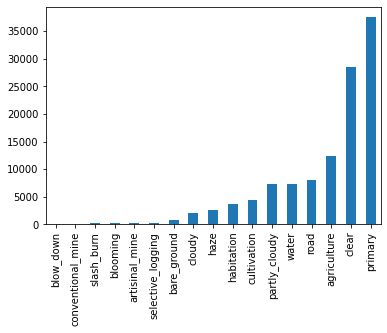

In [ ]:
# HISTOGRAM OF LABEL INSTANCES

train_df[labels].sum().sort_values().plot.bar()

In [ ]:
# CO-OCURRANCE MATRIX 

df_asint = train_df.drop(train_df.columns[[0,1]], axis=1).astype(int)
coc_df = df_asint.T.dot(df_asint)
coc_df

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
agriculture,12315,38,225,32,22,9150,0,24,3377,2737,672,2493,11972,6034,65,119,2712
artisinal_mine,38,339,40,0,0,307,0,4,18,29,5,27,324,110,6,0,299
bare_ground,225,40,862,3,4,747,0,10,89,163,41,74,683,323,13,10,206
blooming,32,0,3,332,1,311,0,0,35,4,4,17,332,10,7,2,16
blow_down,22,0,4,1,98,85,0,0,8,3,0,13,98,2,1,2,3
clear,9150,307,747,311,85,28431,0,70,3527,3090,0,0,27668,6295,308,173,5502
cloudy,0,0,0,0,0,0,2089,0,0,0,0,0,0,0,0,0,0
conventional_mine,24,4,10,0,0,70,0,100,4,36,2,28,94,59,0,0,26
cultivation,3377,18,89,35,8,3527,0,4,4477,895,202,748,4455,1294,58,126,868
habitation,2737,29,163,4,3,3090,0,36,895,3660,129,441,3469,2786,13,41,915


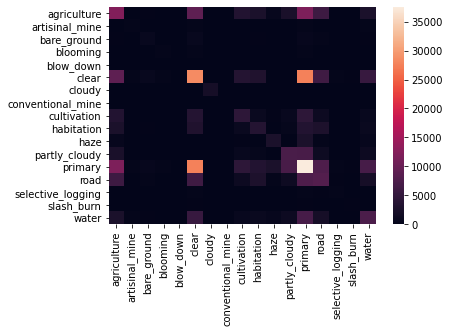

In [ ]:
sns.heatmap(coc_df)

In [ ]:
# INSPECT DATA IMAGES

random_imgs = train_df.loc[random.sample(list(train_df.index), 10)][['image_name', 'tags' ]]

to_read = random_imgs.loc[:, 'image_name'].values
tags = random_imgs.loc[:, 'tags'].values

images = [cv2.imread(os.path.join(PATH/file)) for file in to_read]
print("Number of images:" , len(images))
print("Size of an image", images[0].shape)

Number of images: 10
Size of an image (256, 256, 3)


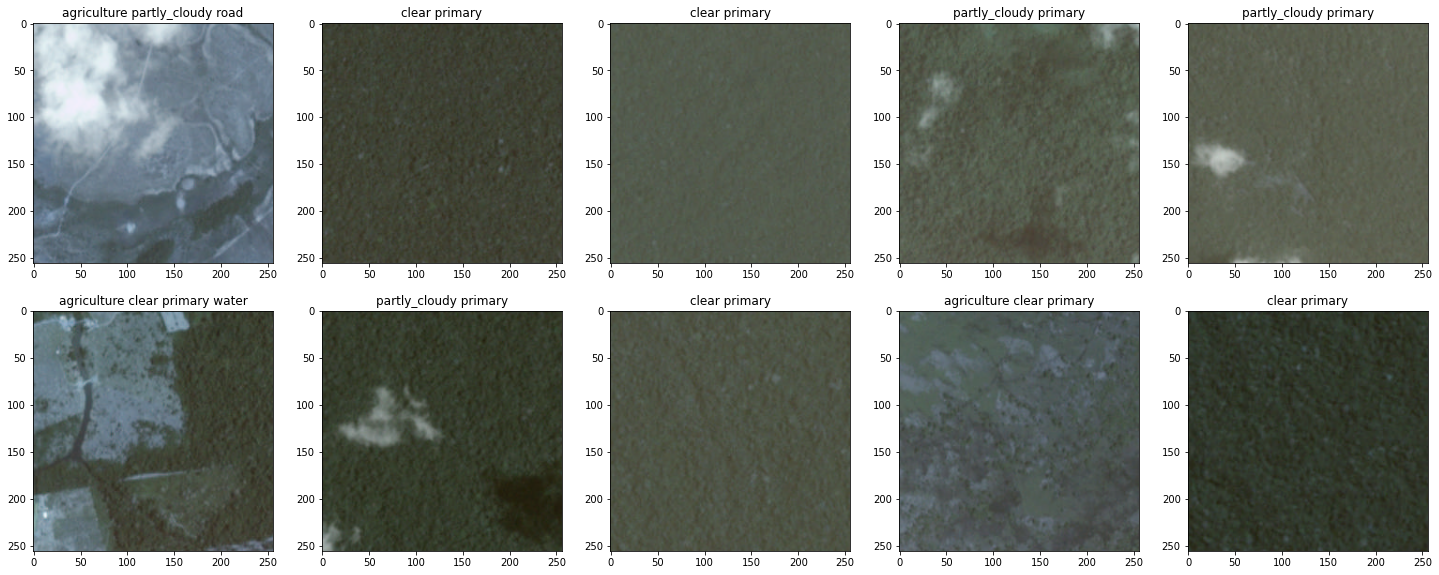

In [ ]:
plt.figure(figsize=(25,15))
columns = 5
for i, image in enumerate(images):
  plt.subplot(len(images) / columns + 1, columns, i + 1)
  plt.imshow(image)
  plt.grid(False)
  plt.title(tags[i])

Fine-tuning a pre-trained model using progressive resizing

In [ ]:
img_size = 128

tfms = get_transforms(do_flip=True,flip_vert=True,p_lighting=0.4,
                      max_lighting=0.3, max_zoom=1.05, max_rotate=360, xtra_tfms=[flip_lr()])

In [ ]:
src = (ImageList.from_df(train_df, PATH, cols='image_name').split_by_rand_pct(0.1).label_from_df(label_delim=" "))

In [ ]:
data = (src.transform(tfms,size=img_size,resize_method=ResizeMethod.CROP)
        .databunch(bs=64,num_workers=4) 
        .normalize(imagenet_stats))

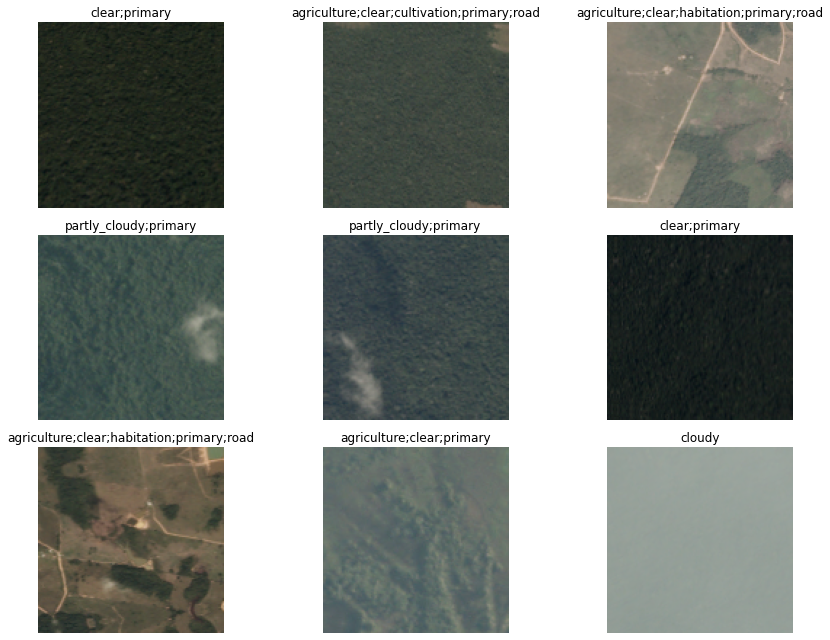

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

In [ ]:
data

ImageDataBunch;

Train: LabelList (36432 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;cultivation;primary;water,haze;primary
Path: /content/gdrive/My Drive/kaggle/planet/planet;

Valid: LabelList (4047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
clear;primary;road;water,agriculture;clear;cultivation;primary,clear;primary,clear;primary,clear;primary
Path: /content/gdrive/My Drive/kaggle/planet/planet;

Test: None

In [ ]:
## LOAD THE PRE-TRAINED MODEL AND CREATE A LEARNER WITH ACCURACY AND F2 SCORE AS METRICS

In [ ]:
arch = models.resnet50
model_name = 'resnet50'

acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

learn = cnn_learner(data, arch, metrics=[acc_02, f_score], model_dir='/models/working')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


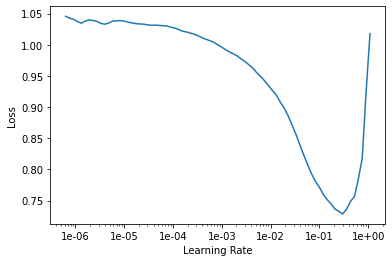

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-2/2
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.248022,0.143875,0.936177,0.883659,1:05:34
1,0.138976,0.116389,0.944621,0.899782,03:17
2,0.123613,0.107029,0.941802,0.906625,03:21
3,0.116267,0.103079,0.949156,0.911076,03:23
4,0.116149,0.101766,0.947194,0.911941,03:22


In [ ]:
learn.model_dir = '/content/gdrive/My Drive/kaggle/planet/planet/models'
learn.save('resnet50-stage1')

In [ ]:
learn.export('resnet50-stage1')

In [ ]:
model_2 = models.densenet121
learn_dense = cnn_learner(data, model_2, metrics=[acc_02, f_score], model_dir='/content/gdrive/My Drive/kaggle/planet/planet/models')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
learn_dense.fit_one_cycle(5, 0.01)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.140193,0.133895,0.942426,0.891184,03:47
1,0.118982,0.105689,0.948516,0.904637,03:36
2,0.106728,0.094626,0.952412,0.918228,03:34
3,0.101719,0.087598,0.955537,0.923587,03:34
4,0.096966,0.085597,0.956235,0.925928,03:31


In [ ]:
learn_dense.save('densenet121-stage1')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


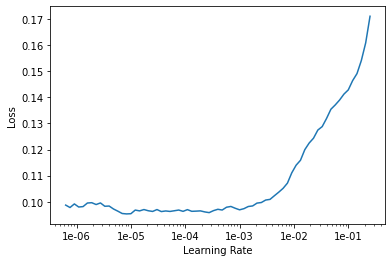

In [ ]:
learn_dense.unfreeze()
learn_dense.lr_find()
learn_dense.recorder.plot()

In [ ]:
learn_dense.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.094022,0.085795,0.955276,0.925228,03:41
1,0.095298,0.085371,0.956511,0.925460,03:40
2,0.092366,0.084666,0.956249,0.926882,03:37
3,0.093417,0.084266,0.956191,0.926340,03:37
4,0.091449,0.084654,0.955581,0.925481,03:34


In [ ]:
learn_dense.save('densenet121-stage2')

In [ ]:
## FINE TUNE USING 256 x 256

data_2 = (src.transform(tfms,size=256,resize_method=ResizeMethod.CROP)
        .databunch(bs=64,num_workers=4) 
        .normalize(imagenet_stats)      
       )

data_2

ImageDataBunch;

Train: LabelList (36432 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;cultivation;primary;water,haze;primary
Path: /content/gdrive/My Drive/kaggle/planet/planet;

Valid: LabelList (4047 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road;water,agriculture;clear;cultivation;primary,clear;primary,clear;primary,clear;primary
Path: /content/gdrive/My Drive/kaggle/planet/planet;

Test: None

In [ ]:
model_2 = models.densenet121
learn_dense_2 = create_cnn(data_2, model_2, metrics=[acc_02, f_score], model_dir='/content/gdrive/My Drive/kaggle/planet/planet/models')

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
learn_dense_2.load('densenet121-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (36432 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
agriculture;clear;primary;water,clear;primary,clear;primary,agriculture;clear;cultivation;primary;water,haze;primary
Path: /content/gdrive/My Drive/kaggle/planet/planet;

Valid: LabelList (4047 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
clear;primary;road;water,agriculture;clear;cultivation;primary,clear;primary,clear;primary,clear;primary
Path: /content/gdrive/My Drive/kaggle/planet/planet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPo

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


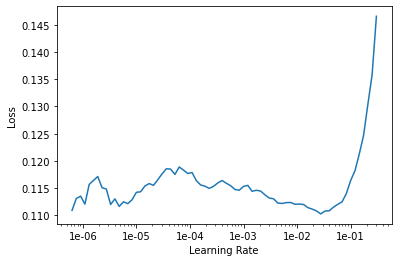

In [ ]:
learn_dense_2.lr_find()
learn_dense_2.recorder.plot()

In [ ]:
learn_dense_2.fit_one_cycle(10, 0.01)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.097367,0.085295,0.955421,0.925791,07:12
1,0.097660,0.088240,0.956337,0.922669,06:47
2,0.104305,0.093174,0.952819,0.914116,06:35
3,0.102621,0.090511,0.954374,0.924857,06:32
4,0.100048,0.090647,0.955828,0.918635,06:23
5,0.098646,0.087380,0.957369,0.923812,06:20
6,0.095229,0.085320,0.953589,0.926970,06:18
7,0.090973,0.083088,0.957688,0.927702,06:15
8,0.090074,0.082177,0.957209,0.928035,06:15
9,0.089863,0.082049,0.957427,0.927720,06:13


In [ ]:
learn_dense.export('densenet121-stage1')
learn_dense.export('densenet121-stage2')
learn_dense.export('densenet121-stage3')

In [ ]:
test = ImageList.from_folder('/content/gdrive/My Drive/kaggle/planet/planet/test-jpg').add(ImageList.from_folder('/content/gdrive/My Drive/kaggle/test-add/test-jpg-additional'))

In [ ]:
len(test)

59395

In [ ]:
model_list = ['resnet50-stage1','densenet121-stage1','densenet121-stage2', 'densenet121-stage3']

In [ ]:
total = np.zeros((len(test), 17))
path = '/content/gdrive/My Drive/kaggle/planet/planet'
for model in model_list:
    learn = load_learner(path, model, test=test)
    preds, targets = learn.TTA(scale=1.05, ds_type=DatasetType.Test)
    #total = np.add(total, np.array(preds))
    
preds_avg = np.divide(total, len(model_list))

KeyboardInterrupt: ignored